In [1]:

from example import process_file
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import RobustScaler
import tensorflow as tf



from rul_pm.dataset.lives_dataset import AbstractLivesDataset
from rul_pm.iterators.iterators import LifeDatasetIterator
from rul_pm.transformation.transformers import Transformer, transformation_pipeline
from rul_pm.transformation.outliers import IQROutlierRemover, ZScoreOutlierRemover
from rul_pm.transformation.imputers import NaNRemovalImputer, RollingMedianImputer, RollingMeanImputer, ForwardFillImputer
from rul_pm.transformation.resamplers import ResamplerTransformer
from rul_pm.iterators.iterators import WindowedDatasetIterator, LifeDatasetIterator
from rul_pm.iterators.batcher import get_batcher
from rul_pm.models.model import FCN

# 1. Dataset

In order to define a dataset you should subclass `AbstractLivesDataset` and define three methods:
    * `__getitem__(self, i)`: This method should return the i-th life 
    * `nlives(self)`: In this method should return the total number of lives present in the dataset

In [2]:
class Dataset(AbstractLivesDataset):
    def __init__(self, file):
        self.lives = [g for _, g in process_file(file).groupby('unit_number')]

    def __getitem__(self, i):
        """

        Returns
        -------
        pd.DataFrame
            DataFrame with the data of the life i
        """
        return self.lives[i]

    @property
    def nlives(self):
        return len(self.lives)

In [3]:
train_dataset = Dataset('train_FD001.txt')
validation_dataset = Dataset('test_FD001.txt')

# 2. Transformers

The transformer class receives 4 parameter:
* The target feature name
* The time feature name
* A pipeline to transform the features
* A pipeline to transform the target

The function transformation_pipeline generates a standard pipeline with steps for outlier removal, missing value imputing, data scaling and resampling.

In [4]:
transformer = Transformer('RUL', 
                  transformerX=transformation_pipeline(
                    outlier=IQROutlierRemover(1.5, 1), 
                    imputer=ForwardFillImputer(),
                    scaler=RobustScaler(),
                    resampler=None))
transformer.fit(train_dataset)

## Iterators

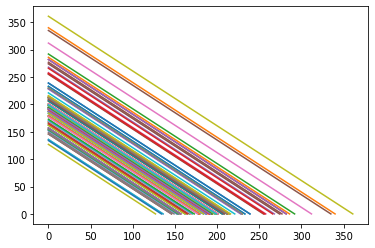

In [5]:
fig, ax = plt.subplots()
it = LifeDatasetIterator(train_dataset, transformer)
for i, (X,y) in enumerate(it):
    ax.plot(y)

## Batcher

The batcher class will return the 

In [6]:
transformer = Transformer('RUL', 
                  transformerX=transformation_pipeline(
                    outlier=IQROutlierRemover(1.5, 1), 
                    imputer=ForwardFillImputer(),
                    scaler=RobustScaler(),
                    resampler=None))
transformer.fit(train_dataset)
window = 25
batch_size = 66
step = 2
train_batcher = get_batcher(train_dataset,  window, batch_size, 
                            transformer, step, shuffle=False)
X, y = next(train_batcher)

### How dos a sample looks like?

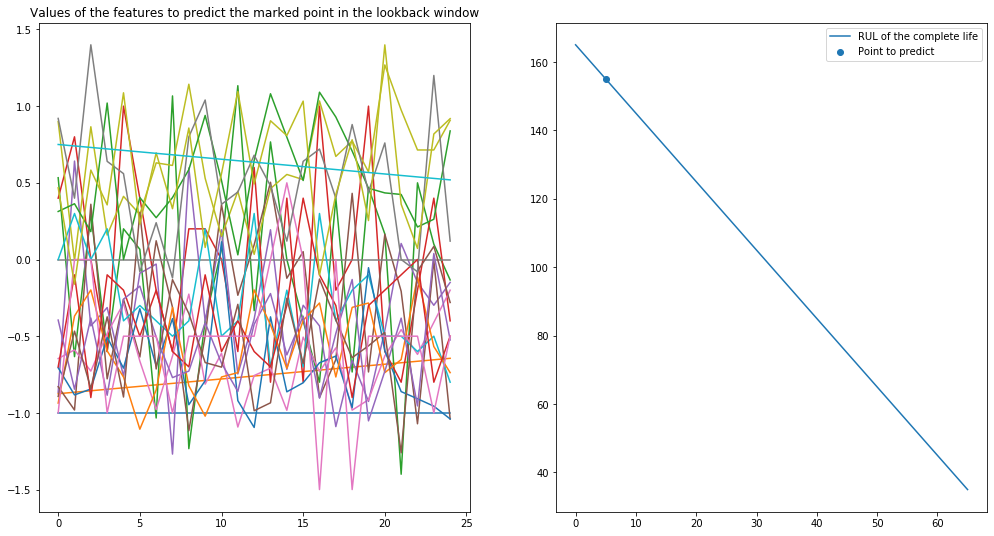

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(17, 9))
for f in range(X.shape[2]):
    ax[0].plot(X[5, :, f])
ax[0].set_title('Values of the features to predict the marked point in the lookback window')
ax[1].plot(y, label='RUL of the complete life')
ax[1].scatter(x=5, y=y[5], label='Point to predict')
ax[1].legend()

# Model

Let's create a simple model in keras with a same dense layers. The TrainableModel creates the batchers for the trainign and validation set and fit the models.

In [8]:
model = FCN([100, 100],
            dropout=0.2,
            l2=0.2,
            window=15,
            batch_size = 16,
            step = 25,
            transformer = Transformer(
                'RUL', 
                transformerX=transformation_pipeline(
                    outlier=IQROutlierRemover(1.5, 1), 
                    imputer=ForwardFillImputer(),
                    scaler=RobustScaler(),
                    resampler=None)
            ),
            shuffle='signal',
            models_path='.',
           patience=7)

model.transformer.fit(train_dataset)
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=0.0001, nesterov=True))
r = model.fit(train_dataset, validation_dataset , epochs=50, verbose=1)

Epoch 1/50
49/49 [==============================] - 0s 7ms/step - loss: 12558.9473 - val_loss: 8566.6338
Epoch 2/50
49/49 [==============================] - 0s 4ms/step - loss: 5877.9893 - val_loss: 1748.4095
Epoch 3/50
49/49 [==============================] - 0s 4ms/step - loss: 1807.6094 - val_loss: 884.9884
Epoch 4/50
49/49 [==============================] - 0s 4ms/step - loss: 1169.1271 - val_loss: 723.0681
Epoch 5/50
49/49 [==============================] - 0s 4ms/step - loss: 902.9517 - val_loss: 474.6748
Epoch 6/50
49/49 [==============================] - 0s 4ms/step - loss: 865.1354 - val_loss: 374.9160
Epoch 7/50
49/49 [==============================] - 0s 4ms/step - loss: 723.9390 - val_loss: 297.2665
Epoch 8/50
49/49 [==============================] - 0s 4ms/step - loss: 754.3810 - val_loss: 367.3761
Epoch 9/50
49/49 [==============================] - 0s 4ms/step - loss: 707.6863 - val_loss: 325.0385
Epoch 10/50
49/49 [==============================] - 0s 5ms/step - loss: 76

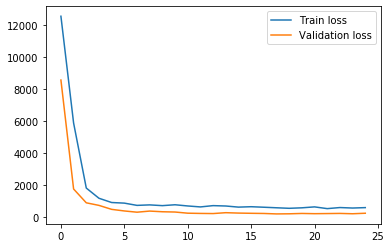

In [9]:
fig, ax = plt.subplots()
ax.plot(r['train_loss'], label='Train loss')
ax.plot(r['val_loss'], label='Validation loss')
ax.legend()

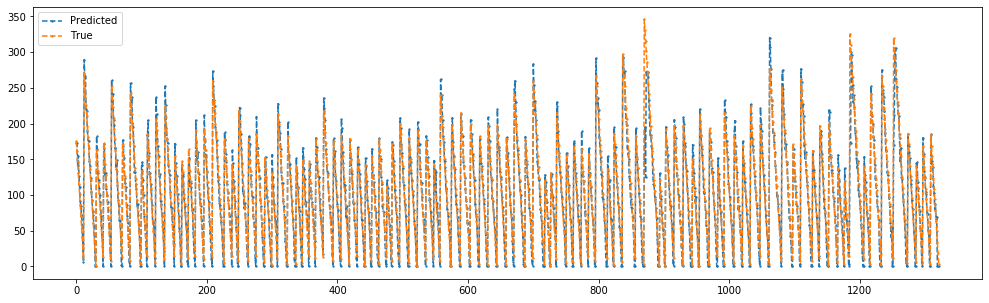

In [12]:
model.load_best_model()
y_pred = model.predict(validation_dataset, step=15)
y_true = model.true_values(validation_dataset, step=15)
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax.plot(y_pred, 'o--', label='Predicted', markersize=1.3)
ax.plot(y_true, 'o--', label='True', markersize=1.3)
ax.legend()

In [ ]:
model.load_best_model()
y_pred = model.predict(validation_dataset, step=15)
y_true = model.true_values(validation_dataset, step=15)
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax.plot(y_pred, 'o--', label='Predicted', markersize=1.3)
ax.plot(y_true, 'o--', label='True', markersize=1.3)
ax.legend()

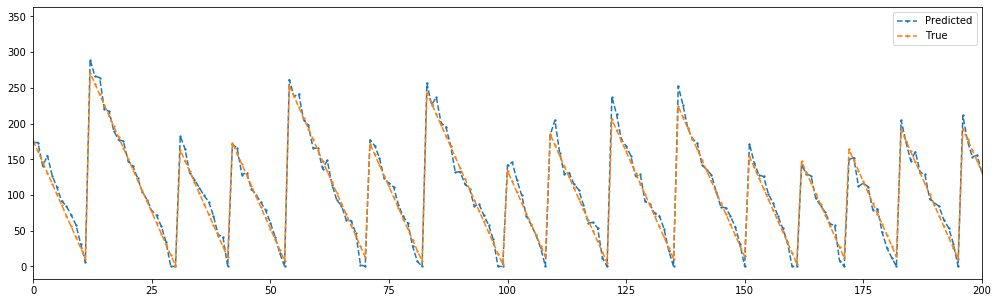

In [14]:
model.load_best_model()
y_pred = model.predict(validation_dataset, step=15)
y_true = model.true_values(validation_dataset, step=15)
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax.plot(y_pred, 'o--', label='Predicted', markersize=1.3)
ax.plot(y_true, 'o--', label='True', markersize=1.3)
ax.set_xlim(0, 200)
ax.legend()